# Flight delays

Your objectives are to create a script that performs a full descriptive statistics for the flight delay in San Francisco. Try to offload as much of the calculations as possible to the database level and investigate what the most common factors for a departure flight delay at the San Francisco airport are. Analyze if there is a significant difference of delay between the carriers at the San Francisco airport in 2016. If so which carriers are better and which worse? Conduct a complete analysis for this part. Finally, create an interactive dashboard that dynamically showcasts your work.

### Language Selection:
I selected to do everything in `python`, it is most convenient for me and its `pandas` module is well suited for data wrangling. Also I make my visualizations using `Bokeh` which is an interactive visualization library for python.

### Variable Selection: 
The downloaded files contain a lot of data and not all variables are necessary, the main variables I used were 'FL_DATE' for dates,'UNIQUE_CARRIER' to identify different airline carriers,'ORIGIN_CITY_NAME' which I chose to be San Francisco, 'DEP_DELAY' which contains the delay in minutes and finally variables that contain information on delay cause, so 'CARRIER_DELAY','WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', and 'LATE_AIRCRAFT_DELAY'. I also considered using destination airport variable and flight duration variable to see if that has any effect on departure delay times, but I ended up keeping the analysis just at delay causes like 'CARRIER_DELAY','WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', and 'LATE_AIRCRAFT_DELAY'. 

In [1]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns

from bokeh.layouts import row, widgetbox, column, layout
from bokeh.models import GeoJSONDataSource, CustomJS, Slider, HoverTool, DateSlider, Select, Span, Title, LinearAxis, Range1d
from bokeh.plotting import figure, show, ColumnDataSource, curdoc
from bokeh.embed import components
from bokeh.models.widgets import DataTable, DateFormatter, TableColumn

from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

###for visualizations within the notebook:
from bokeh.plotting import output_notebook
output_notebook()
   
# ### Load the datasets and join them into one dataframe
# flights_df = pd.read_csv("911734386_T_ONTIME01.csv")

# for n in xrange(2,13):
#     file_name = '911734386_T_ONTIME'+ str(n).zfill(2)+'.csv'
#     flights_df = pd.concat([flights_df,pd.read_csv(file_name, low_memory=False)])

# ### cleaning dataset
# flights_df_cleaned = flights_df.loc[:,['FL_DATE','DAY_OF_WEEK','UNIQUE_CARRIER', 
#                   'ORIGIN_AIRPORT_ID', 'ORIGIN_CITY_NAME', 'DEST_AIRPORT_ID',
#                  'DEP_DELAY', 'CARRIER_DELAY','WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY',
#                  'LATE_AIRCRAFT_DELAY']]
# ### extract just san francisco
# flights_df_sf = flights_df_cleaned[flights_df_cleaned['ORIGIN_CITY_NAME'] == 'San Francisco, CA']
# ### convert FL_DATE into datetime
# flights_df_sf.loc[:,'FL_DATE'] = pd.to_datetime(flights_df_sf.loc[:,'FL_DATE'], format='%Y-%m-%d')

# ### pickle out selected data that I will need:    
# flights_df_sf.to_pickle('transtats.bts.gov_san_fran_2016.pickle')   

### pickle out data
flights_df_sf = pd.read_pickle('transtats.bts.gov_san_fran_2016.pickle')

Loading BokehJS ...

First I will check what % of flights are delayed and what is the distribution of delay times. Delayed departure flights have positive numbers for feature 'DEP_DELAY' which is the difference in minutes between scheduled and actual departure time. Early departures show negative numbers.

In [2]:
### check various stats for delay times

percent_delayed_by_day = [] # list of percent of delayed flights every day
flights_by_day = flights_df_sf.groupby('FL_DATE')
for name, group in flights_by_day:
    num_flights = group.shape[0]
    delayed_flights = group[group['DEP_DELAY']>0].shape[0]
    percent_delayed_by_day.append(round(float(delayed_flights)/num_flights*100,2))

### preparing data for Bokeh
df_percent_delayed_by_day = pd.DataFrame({'percent': percent_delayed_by_day, 'date': np.unique(flights_df_sf['FL_DATE'].values)})
source_percent_delayed_by_day = ColumnDataSource(df_percent_delayed_by_day)

p1 = figure(title = 'Percentage of departure flights that were delayed at San Francisco airport every day in 2016', 
           tools= 'box_zoom,pan,save,reset', width=900, height=300, active_drag="box_zoom", x_axis_type="datetime",
           x_axis_label='Date', y_axis_label='% of flights delayed')

p1.line(x = 'date', y = 'percent', source = source_percent_delayed_by_day, line_color="#00cc99", line_width=2)

### add a hover tool
delays_hover = HoverTool(
    tooltips=[
        ( 'Date',   '@date{%d-%b-%Y}'            ),
        ( 'Percent of Flights Delayed', '@percent'      ),
    ],

    formatters={
        'date'      : 'datetime', # use 'datetime' formatter for 'date' field
                                  # use default 'numeral' formatter for other fields
    },
    # display a tooltip whenever the cursor is vertically in line with a glyph
    mode='vline'
)

p1.add_tools(delays_hover)

p1.xaxis.major_label_text_font_size = "12pt"
p1.yaxis.major_label_text_font_size = "14pt"
p1.title.text_font_size = '14pt'
p1.yaxis.axis_label_text_font_size = "15pt"
p1.xaxis.axis_label_text_font_size = "15pt"
show(p1)


The timeseries shows the percentage of departure flights at San Francisco airport that were delayed for each day in 2016. If you hover above any point in the timeseries with your cursor, you can see the exact % of flights delayed on a given day. You can zoom in by pushing down your left mouse button and selecting a quadrant of choice. By clicking the 'reverse' icon on the right of the plot you can rescale back to the original plot.<br>
There is no visible trend or obvious seasonality in the time series of the % of departure flights delayed each day. I will next check the distribution of % of departure flights delayed.

In [3]:
### make a histogram plot of percentage of flights delayed

### prepare histogram
hist, edges = np.histogram(percent_delayed_by_day, density=True, bins=30)

### prepare a stats table
stats_done = ['min','max','median','mean','std','var']
stats = []
stats.append(np.amin(percent_delayed_by_day))
stats.append(np.amax(percent_delayed_by_day))
stats.append(np.median(percent_delayed_by_day))
stats.append(np.mean(percent_delayed_by_day))
stats.append(np.std(percent_delayed_by_day))
stats.append(np.var(percent_delayed_by_day))
### prepare stats table for Bokeh
stats_df = pd.DataFrame({'Numbers' : np.around(stats,2), 'Stats': stats_done})
stats_source = ColumnDataSource(stats_df)

### make a table
stats_columns = [
        TableColumn(field="Stats", title=" "),
        TableColumn(field="Numbers", title=" ")
    ]
stats_data_table = DataTable(source=stats_source, columns=stats_columns, width=300,height=400, reorderable=False)


### bokeh histogram plot
p2 = figure(tools= 'box_zoom,pan,save,reset', width=550,height=300, active_drag="box_zoom",
           x_axis_label='% of flights that were delayed', y_axis_label='proportion of days')

p2.quad(top=hist/np.sum(hist), bottom=0, left=edges[:-1], right=edges[1:],
        fill_color="#00cc99", line_color="black")

p2.xaxis.major_label_text_font_size = "12pt"
p2.yaxis.major_label_text_font_size = "14pt"
p2.yaxis.axis_label_text_font_size = "15pt"
p2.xaxis.axis_label_text_font_size = "15pt"
p2.add_layout(Title(text="delayed at San Francisco airport every day in 2016", text_font_size="10pt"), 'above')
p2.add_layout(Title(text="Histogram of percentage of departure flights that were", text_font_size="10pt"), 'above')

l2 = layout([
  [p2, stats_data_table]
])

show(l2)

The histogram on the left and the table on the right show that across the days in 2016 the % of departure flighst delayed is between 14.34% and 76.21%. On average 38.78% of departure flight are delayed in a given day. <br>
Now I will look at the stats of the magnitude of delay times for flights that were delayed.

In [4]:
### how long are average delay times every day

avg_minutes_delayed_by_day = [] # list of percent of delayed flights every day
max_minutes_delayed_by_day = [] # list of percent of delayed flights every day

flights_by_day = flights_df_sf.groupby('FL_DATE')
for name, group in flights_by_day:
    delayed_flights = group[group['DEP_DELAY']>0]
    max_minutes_delayed_by_day.append(delayed_flights['DEP_DELAY'].max())
    avg_minutes_delayed_by_day.append(delayed_flights['DEP_DELAY'].mean())

### preparing data for Bokeh
df_avg_minutes_delayed_by_day = pd.DataFrame({'delay': avg_minutes_delayed_by_day, 'date': np.unique(flights_df_sf['FL_DATE'].values)})
df_max_minutes_delayed_by_day = pd.DataFrame({'delay': max_minutes_delayed_by_day, 'date': np.unique(flights_df_sf['FL_DATE'].values)})
source_avg_minutes_delayed_by_day = ColumnDataSource(df_avg_minutes_delayed_by_day)
source_max_minutes_delayed_by_day = ColumnDataSource(df_max_minutes_delayed_by_day)

p3 = figure(title = 'Minutes of delay for delayed departure flights at San Francisco airport every day in 2016', 
           tools= 'box_zoom,pan,save,reset', width=900, height=300, active_drag="box_zoom", x_axis_type="datetime",
           x_axis_label='Date', y_axis_label='minutes of delay')

p3.line(x = 'date', y = 'delay', source = source_max_minutes_delayed_by_day, line_color="#99ff33", line_width=2, 
        legend="Maximum delay in minutes")
p3.line(x = 'date', y = 'delay', source = source_avg_minutes_delayed_by_day, line_color="#009999", line_width=2, 
        legend="Average delay in minutes")

### add a hover tool
minute_delays_hover = HoverTool(
    tooltips=[
        ( 'Date',   '@date{%d-%b-%Y}'            ),
        ( 'Delay in Minutes', '@delay'      ),
    ],

    formatters={
        'date'      : 'datetime', # use 'datetime' formatter for 'date' field
                                  # use default 'numeral' formatter for other fields
    }
)

p3.add_tools(minute_delays_hover)

p3.legend.location = "top_left"
p3.legend.glyph_width = 50
p3.xaxis.major_label_text_font_size = "12pt"
p3.yaxis.major_label_text_font_size = "14pt"
p3.title.text_font_size = '14pt'
p3.yaxis.axis_label_text_font_size = "15pt"
p3.xaxis.axis_label_text_font_size = "15pt"
show(p3)


The two timeseries above show the maximum minutes of delay (light green) and average minutes of delay (dark green) for each day in 2016. If you hover above any of the two timeseries with your cursor, you can see the exact number of minutes of delay on a given day. <br>
Scroll below to see the two timeseries as distributions.

In [5]:
### prepare histogram of minutes delayed
avg_hist, avg_edges = np.histogram(avg_minutes_delayed_by_day, density=True, bins=40)
max_hist, max_edges = np.histogram(max_minutes_delayed_by_day, density=True, bins=40)

### prepare a stats table of max delay times
stats_done = ['min','max','median','mean','std','var']
stats_max = []
stats_max.append(np.amin(max_minutes_delayed_by_day))
stats_max.append(np.amax(max_minutes_delayed_by_day))
stats_max.append(np.median(max_minutes_delayed_by_day))
stats_max.append(np.mean(max_minutes_delayed_by_day))
stats_max.append(np.std(max_minutes_delayed_by_day))
stats_max.append(np.var(max_minutes_delayed_by_day))
### prepare stats max table for Bokeh
stats_max_df = pd.DataFrame({'Numbers' : np.around(stats_max,2), 'Stats': stats_done})
stats_max_source = ColumnDataSource(stats_max_df)

### prepare a stats table of mean delay times
stats_done = ['min','max','median','mean','std','var']
stats_mean = []
stats_mean.append(np.amin(avg_minutes_delayed_by_day))
stats_mean.append(np.amax(avg_minutes_delayed_by_day))
stats_mean.append(np.median(avg_minutes_delayed_by_day))
stats_mean.append(np.mean(avg_minutes_delayed_by_day))
stats_mean.append(np.std(avg_minutes_delayed_by_day))
stats_mean.append(np.var(avg_minutes_delayed_by_day))
### prepare stats max table for Bokeh
stats_mean_df = pd.DataFrame({'Numbers' : np.around(stats_mean,2), 'Stats': stats_done})
stats_mean_source = ColumnDataSource(stats_mean_df)

### make the two tables
max_stats_columns = [
        TableColumn(field="Stats", title=" "),
        TableColumn(field="Numbers", title=" ")
    ]
max_stats_data_table = DataTable(source=stats_max_source, columns=max_stats_columns, width=300,height=400, reorderable=False)

mean_stats_data_table = DataTable(source=stats_mean_source, columns=max_stats_columns, width=300,height=400, reorderable=False)

### make two bokeh histogram plots
p4 = figure(tools= 'box_zoom,pan,save,reset', width=500, height=300, active_drag="box_zoom",
           x_axis_label='average delay in minutes', y_axis_label='proportion of days')

p4.quad(top=avg_hist/np.sum(avg_hist), bottom=0, left=avg_edges[:-1], right=avg_edges[1:],
        fill_color="#009999", line_color="black")

p4.xaxis.major_label_text_font_size = "12pt"
p4.yaxis.major_label_text_font_size = "14pt"
p4.yaxis.axis_label_text_font_size = "15pt"
p4.xaxis.axis_label_text_font_size = "15pt"
p4.add_layout(Title(text="at San Francisco airport every day in 2016", text_font_size="10pt"), 'above')
p4.add_layout(Title(text="Histogram of average delays in minutes", text_font_size="10pt"), 'above')

p5 = figure(tools= 'box_zoom,pan,save,reset', width=500, height=300, active_drag="box_zoom",
           x_axis_label='maximum delay in minutes', y_axis_label='proportion of days')

p5.quad(top=max_hist/np.sum(max_hist), bottom=0, left=max_edges[:-1], right=max_edges[1:],
        fill_color="#99ff33", line_color="black")

p5.xaxis.major_label_text_font_size = "12pt"
p5.yaxis.major_label_text_font_size = "14pt"
p5.yaxis.axis_label_text_font_size = "15pt"
p5.xaxis.axis_label_text_font_size = "15pt"
p5.add_layout(Title(text="at San Francisco airport every day in 2016", text_font_size="10pt"), 'above')
p5.add_layout(Title(text="Histogram of maximum delays in minutes", text_font_size="10pt"), 'above')

l4 = layout([
  [p4, widgetbox(mean_stats_data_table)],
])
l5 = layout([
    [p5, widgetbox(max_stats_data_table)]
])

show(l4)

The histogram and datatable above show that on average the average delay time of a delayed departure flight is 34.07 minutes. There were a couple days in that year where the average departure delay was a high as 87.44 minutes and on the other hand on some days the avergae delay was a small as 15.74 minutes. 

In [6]:
show(l5)

The histogram and datatable of maximum delay times in a given day show that on average the maximum delay time of delayed departure flights is 366 minutes. <br>
Now checking for the most common factor for a delay. The columns 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', and 'LATE_AIRCRAFT_DELAY' record the number of minutes of delay each category is responsible for. I will sum up the numbers for each category and normalize by total number of minutes of delay in the whole 2016 to see what percentage of delay is due to CARRIER, WEATHER, NAS, SECURITY, and LATE AIRCRAFT.


In [7]:
### check for most common factor for delay

causes_df = flights_df_sf.loc[:,['DEP_DELAY','CARRIER_DELAY','WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']]
causes_df = causes_df[causes_df['DEP_DELAY']>0]   ### only look at flights taht have a delay
### sum across all columns and normalize
delay_causes = np.around(causes_df.sum()/causes_df.sum()[0]*100,2)

### prepare data for Bokeh
causes_list = ['Carrier Delay','Weather', 'National Air System', 'Security', 'Late Aircraft']
percentage_df = pd.DataFrame({'percentage' : delay_causes[1:], 'causes': causes_list}).reset_index().iloc[:,1:]
percentage_source = ColumnDataSource(percentage_df)

### make a table
columns = [
        TableColumn(field="causes", title="Flight Delay Cause"),
        TableColumn(field="percentage", title="Percent % of Cases")
    ]
data_table = DataTable(source=percentage_source, columns=columns, width=320, reorderable=False)


### the plot
p6 = figure(title = 'Factors for departure flight delays at San Francisco Airport in 2016', 
           tools= 'box_zoom,pan,save,reset', width=600, height=400, active_drag="box_zoom", x_range = causes_list)

### just add a horizontal line at 0
hline = Span(location=0, dimension='width', line_color='black', line_width=2)
p6.add_layout(hline)

p6.segment(causes_list, delay_causes[1:], causes_list, 0, line_width=3,alpha = 0.5, line_color="black" )
p6.circle(causes_list, delay_causes[1:], size=20, fill_color="crimson", line_color="black", line_width=3, )

p6.xaxis.major_label_text_font_size = "12pt"
p6.yaxis.major_label_text_font_size = "14pt"
p6.title.text_font_size = '12pt'
p6.yaxis.axis_label = '% of the delay caused'
p6.yaxis.axis_label_text_font_size = "15pt"

show(row(p6, widgetbox(data_table)))


The most common factor is the Late Aircraft (accounts for 48.17% of delay times) followed by Carrier Delay (responsible for 25.64% of delay times). So it is interesting to look at how different carriers perform. I look at the Unique Carrier Code feature to distinugish carriers. I could look at only delays where 'Carrier Delay' is the one responsible and I could compare carriers among one another. However I will look at all delays for each carrier, regardless of what the assigned cause for the delay was. My assumption here is that any causes that are not a carrier's fault should be the same for all carriers so it should average out, which means I can compare different carriers by looking at all delay times for each carrier. <br>
Let me now check if there is a statistical difference in delay times between different carriers. For each carrier I gather all delay times for all delayed flights and first I will plot that.

In [8]:
carriers_delay_df = flights_df_sf.loc[:,['UNIQUE_CARRIER','DEP_DELAY']]
carriers_delay_df = carriers_delay_df[carriers_delay_df['DEP_DELAY']>0]

carriers_list = list(carriers_delay_df['UNIQUE_CARRIER'].unique())

p7 = figure(title = 'Delay amounts in minutes for various carriers at San Francisco Airport in 2016', 
           tools= 'box_zoom,pan,save,reset', width=650, height=400, active_drag="box_zoom", x_range = carriers_list,
           toolbar_sticky=False, y_axis_type="log")

carrier_means = []
carrier_grps = carriers_delay_df.groupby('UNIQUE_CARRIER')
for name, group in carrier_grps:
    my_y = group["DEP_DELAY"].values
    carrier_means.append(round(my_y.mean(),2))
    p7.circle(x=[name for i in xrange(0,len(my_y))], y=my_y, color='crimson', size = 10, alpha = 0.3, line_color = 'maroon')
    p7.circle(x =[name for i in xrange(0,1)], y=my_y.mean(), fill_color="#00ffcc", size = 13, line_color = 'black')

### prepare data table
carrier_means_df = pd.DataFrame({'mean' : carrier_means, 'carriers': carriers_list}).reset_index().iloc[:,1:]
carrier_means_source = ColumnDataSource(carrier_means_df)

### make a table
carrier_columns = [
        TableColumn(field="carriers", title="Carrier Code"),
        TableColumn(field="mean", title="Mean delay in minutes")
    ]
carrier_data_table = DataTable(source=carrier_means_source, columns=carrier_columns, width=320, reorderable=False)

    
p7.xaxis.major_label_text_font_size = "12pt"
p7.yaxis.major_label_text_font_size = "14pt"
p7.title.text_font_size = '11pt'
p7.yaxis.axis_label = 'delay'
p7.yaxis.axis_label_text_font_size = "15pt"
p7.xaxis.axis_label = 'Unique Carrier Code'
p7.xaxis.axis_label_text_font_size = "15pt"

show(row(p7, widgetbox(carrier_data_table)))


The plot above shows delay amounts in minutes (on a logarithmic scale) for every delayed flight in 2016 for a given carrier. The aqua colored dot for every carrier is the average delay in minutes. There might be some difference across carriers.<br>
Now I will check if there is statistical significance in difference between carriers. For each carrier I gather all delay times for all delayed flights and I will use a Tukey's range test, a common post hoc analysis method to compare all possible pairs of carriers and identify those pairs of carriers that differ.

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower    upper   reject
-----------------------------------------------
  AA     AS    0.6285  -4.1891   5.4462  False 
  AA     B6    0.312   -3.8184   4.4424  False 
  AA     DL   -4.3467  -7.9295  -0.7638   True 
  AA     F9   17.1311  11.1638  23.0983   True 
  AA     HA   -15.1041 -27.2196 -2.9887   True 
  AA     OO    4.9217   2.0982   7.7451   True 
  AA     UA   -5.6976  -8.3266  -3.0686   True 
  AA     VX   -9.5535  -12.5576 -6.5494   True 
  AA     WN   -4.7826  -7.9401  -1.6251   True 
  AS     B6   -0.3165  -5.6941   5.0611  False 
  AS     DL   -4.9752  -9.9446  -0.0057   True 
  AS     F9   16.5026   9.613   23.3921   True 
  AS     HA   -15.7327 -28.328  -3.1373   True 
  AS     OO    4.2931   -0.16    8.7463  False 
  AS     UA   -6.3262  -10.6586 -1.9937   True 
  AS     VX   -10.182  -14.7518 -5.6123   True 
  AS     WN   -5.4112  -10.0832 -0.7391   True 
  B6     DL   -4.6587  -8.9651  -0.35

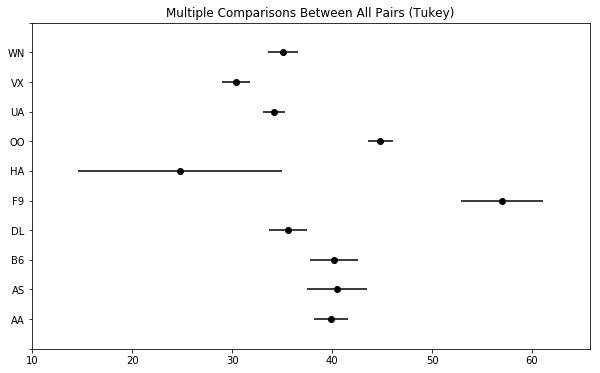

In [9]:
mc = MultiComparison(carriers_delay_df['DEP_DELAY'], carriers_delay_df['UNIQUE_CARRIER'])
result = mc.tukeyhsd()
print(result)
result.plot_simultaneous()

Tukeyhsd Multicomparison tests for significant differences in group means and what it returns for us is for every unique carrier (here on y axis in the plot above) it plots an interval. Significant differences between two carriers at the alpha=0.05 level can be identified by intervals that do NOT overlap So any two pairs can be compared for significance by looking for overlap. For example carrier F9 which is Frontier Airlines has an interval that does not overlap with any other airline so it is statistically significantly different from all the rest. And it is the worst performing airline. The best performing airline is Hawaiian Airlines however it does not siginificantly differ from WN, VX, UA and DL.<br>
Now I will also check for each airline the percentage of flights delayed.

In [10]:
### I will look at the % of flights delayed
carriers_df = flights_df_sf.loc[:,['UNIQUE_CARRIER','DEP_DELAY']]
carrier_grps = carriers_df.groupby('UNIQUE_CARRIER')

carriers_list = list(carriers_df['UNIQUE_CARRIER'].unique())
carrier_percent_delayed = [] # % of flights delayed for each carrier
for name, group in carrier_grps:
    num_flights = group.shape[0]
    delayed_flights = group[group['DEP_DELAY']>0].shape[0]
    carrier_percent_delayed.append(round(float(delayed_flights)/num_flights*100,2))
    
### sort both by size
new_indices = sorted(range(len(carrier_percent_delayed)), key=lambda k: carrier_percent_delayed[k])
carriers_list = [carriers_list[i] for i in new_indices]
carrier_percent_delayed = [carrier_percent_delayed[i] for i in new_indices]

### the plot
p8 = figure(title = 'Delayed departure flights for various carriers at San Francisco Airport in 2016', 
           tools= 'box_zoom,pan,save,reset', width=700, active_drag="box_zoom", x_range = carriers_list,
           toolbar_sticky=False)

### just add a horizontal line at 0
hline = Span(location=0, dimension='width', line_color='#00ffcc',line_alpha = 0.3,  line_width=2)
p8.add_layout(hline)


p8.segment(carriers_list, carrier_percent_delayed, carriers_list, 0, line_width=3,alpha = 0.3, line_color="#00ffcc" )
p8.circle(carriers_list, carrier_percent_delayed, size=20, fill_color="#00ffcc", line_color="black", line_width=3, )
p8.yaxis.axis_label = "percent of flghts delayed"

p8.xaxis.major_label_text_font_size = "12pt"
p8.yaxis.major_label_text_font_size = "14pt"
p8.title.text_font_size = '11pt'
p8.yaxis.axis_label_text_font_size = "15pt"
p8.xaxis.axis_label = 'Unique Carrier Code'
p8.xaxis.axis_label_text_font_size = "15pt"

show(p8)

The plot above shows the percent of flights delayed for each carrier (aqua color, yaxis on the left). In terms of the percentage of delayed departure flights, the carrier with the lowest percentage of flights delayed is Hawaiian Airlines, followed by JetBlue Airways, Alaska Airlines, Delta Air Lines, SkyWest Airlines, and then the carriers performing worse in terms of percentage of flights delayed are Frontier Airlines, Southwest Airlines, Virgin America and at the very end American Airlines and United Airlines. 